# _Python for Scientific Data Analysis_

# SciPy

## Section 3: Statistics (continued)

In [2]:
 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import scipy

#and because this is a Jupyter notebook
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize']=[8,6]

### Statistical Tests of Data (Frequentist Perspective)

#### Chi-Squared Test and Goodness of Fit


When comparing data and models we are typically
doing one of two things:

• _Hypothesis testing_ : we have a set of $N$ measurements with individual measurements $i$.  These measurements have values $x_{i}$ and uncertainties $\sigma_{i}$.  We compare the data to some model, which says that these measurements should have values $\mu_{i}$.   

We want to quantify how consistent the observable data are with the model.  The way to do this is to compute some test statistic that tells us the probability of obtaining data at least as discrepant from the model predictions as $x_{i}$ if the model is correct.  

• _Parameter estimation_ : we have a parameterized model
which describes the data, such as $y = mx + b$, and we
want to determine the best-fitting parameters (m and b) and uncertainties in these parameters, such as standard errors or confidence intervals. 



_Chi-Square_

The chi-squared statistic ($\chi^{2}$) is first stop to an answer.  It is a quantitative measure of the goodness-of-fit of the data to the model.  In its simple form -- assuming that the measurments and their errors are independent (more on this later) -- of the following:

$\chi^{2}$ = $\sum_{i=1}^{N}$$\frac{(x_{i}-\mu_{i})^{2}}{\sigma_{i}^{2}}$.

Note that this is a different thing than the Pearson chi-square statistic which is $\sum_{i=1}^{N}$$\frac{(x_{i}-\mu_{i})^{2}}{\mu_{i}}$, which does not consider measurement error and isn't useful in our context below.  The Pearson chi-square is most useful in the simple case where you have expected and observed discrete numbers of events.

Anyway, the chi-squared statistic ($\chi^{2}$) penalizes the model according to how many standard deviations each data point lies from the model.  E.g. if the measurement $i$ is $x_{i}$ = 2 and $\sigma_{i}$ = 0.5 (so the measurement is 2$\pm$ 0.5) and the model predicts 3, then this is a 2-$\sigma$-discrepant prediction for $i$ and the $\chi^{2}$ contribution from that data point is equal to 4. 

For Gaussian-distributed variables, the chi-squared statistic has a probability distribution function (PDF) of 
$P(\chi^{2})$ $\propto$ ($\chi^{2}$)$^{(\nu -2)/ 2} e^{-\chi^{2}/2}$. 

The full form looks slightly more involved:

$P(\chi^{2})$ = $(2^{\nu/2}\Gamma(\nu/2))^{-1}$($\chi^{2}$)$^{(\nu -2)/ 2} e^{-\chi^{2}/2}$

Here, $\nu$ equals "degrees of freedom".  $\Gamma$ is the gamma function which is accessed by ``from scipy.special import gamma`` with the call ``gamma([number])``.

The other, simpler way of calculating the $\chi^{2}$ PDF is a SciPy function call ``scipy.stats.chi2``, using the ``pdf`` function:

```
from scipy.stats import chi2

#initialize some range of chisquared values
chisqval=np.arange(0,1000,0.01) 

#dof 
chispdf=chi2.pdf(chisqval,dof)
```

 If the model has no free parameters then $\nu$ = $N$.   But if we are fitting a model with $p$ free parameters, then we can
“force the model to exactly agree with p data points”, and so $\nu = N - p$.  Note we almost always have at least one free parameter when we do model fitting.

  ![](./figures/chisquaredist.png)

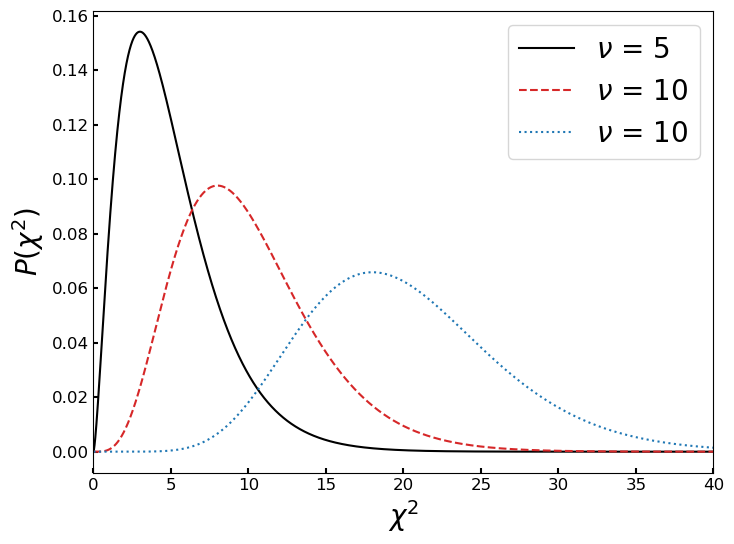

In [3]:
from scipy.stats import chi2

chisqval=np.arange(0,1000,0.01)

dofrange=[5,10,20]

import matplotlib.pyplot as plt
fig,axes=plt.subplots(figsize=(8,6))

axes.plot(chisqval,chi2.pdf(chisqval,dofrange[0]),c='black',linestyle='solid',label='$\\nu $ = {0}'.format(dofrange[0]))
axes.plot(chisqval,chi2.pdf(chisqval,dofrange[1]),c='tab:red',linestyle='--',label='$\\nu $ = {0}'.format(dofrange[1]))
axes.plot(chisqval,chi2.pdf(chisqval,dofrange[2]),c='tab:blue',linestyle='dotted',label='$\\nu $ = {0}'.format(dofrange[1]))
axes.set_xlim(0,40)
axes.tick_params(which='both',width=1.5,direction='in',labelsize='large')
axes.set_ylabel(r'$P(\chi^{2})$',size=20)
axes.set_xlabel(r'$\chi^{2}$',size=20)
axes.legend(fontsize=20)
plt.show()

In each case, the mean of the distribution is related to the number of degrees of freedom ... and by related I mean equal: $\bar{\chi^{2}}$ = $\nu$ = $N-p$.   The variance is also related: $Var{(\chi^{2})}$ = 2$\nu $.   

Thus, if the model is correct and if our measurement errors are accurate (i.e. they are not underestimated or inflated), we would expect:

$\chi^{2}$ $\sim$ $\nu$ $\pm$ $\sqrt{2\nu}$ 

One can understand this intuitively.  Each data point should contribute about $\sim$1-$\sigma$ from the model and hence $\sim$ 1 to the $\chi^{2}$ statistic.

#### reduced chi-squared

A perhaps more useful way to describe the goodness-of-fit is the _reduced_ chi-squared, which is $\chi^{2}/\nu$.   I.e. the $\chi^{2}$ per degree of freedom.   For a good fit --and again assumes our errors are accurate -- we expect $\chi^{2}/\nu$ $\sim$ 1 $\pm$ $\sqrt{2/\nu}$ because $\bar{\chi^{2}} = \nu$ (i.e. because the residuals are expected to be consistent with noise).   

The true likelihood of the data being consistent with the model depends on both $\chi^{2}$ and $\nu$.   In other words, our interpretation of what $\chi^{2}/\nu$ means depends on the number of degrees of freedom $\nu $. 

As a very general statement, the rules of thumb hold:

* if $\chi^{2}_{\nu}$ $\approx$ 1, then the model describes the data about as well as expected given the estimated errors.
* if $\chi^{2}_{\nu}$ $\gg$ 1, then either i ) the model is a poor fit or ii ) the errors are substantially underestimated.
* if $\chi^{2}_{\nu}$ $\ll$ 1, then the model fits _too_ well: crudely, the model might be "too good to be true".  Here are the errors are either i ) overestimated or ii ) properly estimated but so large that even a very different model would provide a comparably good fit.

We will get to this idea more below when we discuss p-values.
 

#### Correlated Errors

So far, our $\chi^{2}$ equation assumes that each measurement and the errors associated with them are independent.   To understand what this means, consider a matrix where each element at column $i$ and row $j$ corresponds to a pair of measurement errors.   For truly independent errors, the off-diagonal elements are zero, while the diagonal elements are equal to the variance of each measurement of the data ($\sigma^{2}$).  

But sometimes the errors are coupled and the measurement values are correlated. The attached image shows an example (from Greco & Brandt 2017):

![](./figures/speccovar.png)

Here, the green circle shows the hypothetical position of a planet.   The signal shows speckle pattern.    In high-contrast imaging data taken with an integral field spectrograph (think "images at a bunch of different wavelengths all at once"), the speckle pattern appears to propagate outwards with wavelength.   If you would measure the brightness of the planet at, say, 1.65 $\mu m$, its signal would be affected by the speckle (orange-yellow stuff).  Measurements at 1.575 $\mu m$ and 1.725 $\mu m$ would likewise be affected.   Therefore, our measurements of the planet flux density in each of these three channels are coupled (i.e. they are dependent upon the modeling/removal of the signal of the same speckle viewed at different wavelengths).

For correlated errors, the $\chi^{2}$ equation is a bit more complicated:

$\chi^{2} = \sum_{i=1}^{N}\sum_{j=1}^{N} (x_{i}-\mu_{i})(C^{-1})_{ij} (x_{j}-\mu_{j})$

In vector-matrix notation this ends up being ...

$\chi^{2}$ = ($\textbf{x}$-$\mu$)$^{T}$ $\textbf{C}^{-1}$ ($\textbf{x}$-$\mu$)

Here, $\textbf{C}$ is the covariance matrix.   As an example, for two measurments, the covariance matrix looks like:

$\textbf{C}$ = $\left[ {\begin{array}{cc}
   \sigma_{1}^{2} & \rho_{12}\sigma_{1}.\sigma_{2} \\
   \rho_{12}\sigma_{2}.\sigma_{1} & \sigma_{2}^{2}\\
  \end{array} } \right]$ 


Here $\rho_{12}$ is the correlation coefficient between errors $\sigma_{1}$ and $\sigma_{2}$.  If the measurements $1$ and $2$ and their uncertainties are truly uncorrelated, then the off-diagonal terms go to zero and we recover the familiar equation describing the goodness-of-fit.   Otherwise, if they are correlated (as in the above example), then we need to consider the full covariance of the data.

#### p-values

If the model is correct [our hypothesis], what is the probability that this value of
chi-squared, or a larger one, could arise by chance?  This probability is called the p-value and may be
calculated from the chi-squared distribution.  

To understand how this works, we first calculate the _cumulative distribution function_ (CDF) of our $\chi^{2}$ distribution.  This is accessed from ``chi2.cdf`` from ``scipy.stats``:

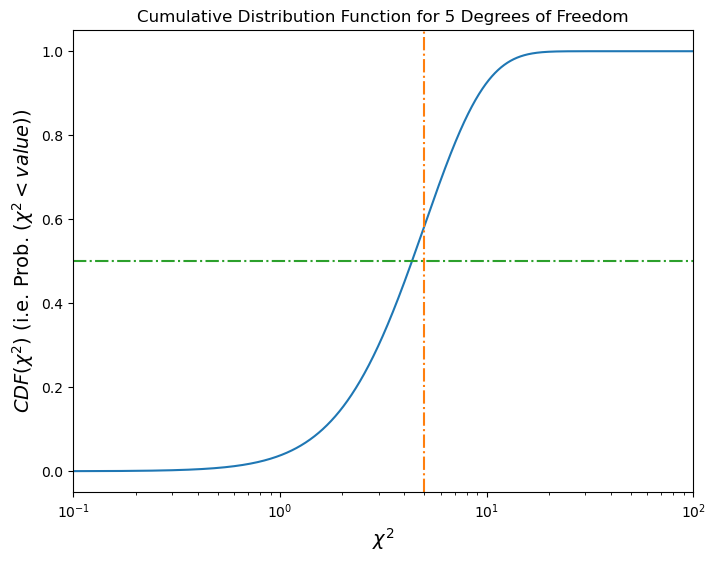

In [5]:

#array of chisq values

chisqval=np.arange(0,1000,0.01)

#choose some number of degrees of freedom

dof=5

cdf=chi2.cdf(chisqval,dof)

plt.plot(chisqval,cdf)
plt.xlim(0.1,100)
plt.axhline(0.5,ls='-.',color='tab:green')
plt.axvline(5,ls='-.',color='tab:orange')
plt.title('Cumulative Distribution Function for {0:s} Degrees of Freedom'.format(str(dof)))
#plt.xlabel('x')
#plt.ylabel('P(X) $<$ x')
plt.xlabel(r'$\chi^{2}$',fontsize=14)
plt.ylabel(r'$CDF(\chi^{2})$ (i.e. Prob. ($\chi^{2} < value$))',fontsize=14)
plt.xscale('log')

In the below example I plot the cumulative distribution function for a chi-squared distribution with 5, 10, and 20 degrees of freedom (i.e. as in the previous figure).

As before, don't worry about all the Matplotlib trickery for now.  We will cover it later.

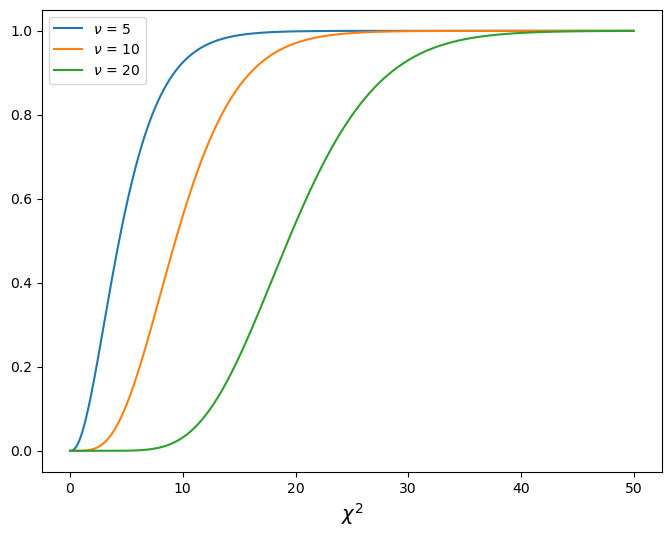

In [14]:

#import matplotlib.pyplot as plt

#list of degrees of freedom
dof=[5,10,20]

chisq=np.arange(0,50,0.01) #a subset of values

#a for-loop plotting the CDF for different degrees of freedom
for i in range(len(dof)):
 plt.plot(chisq,chi2.cdf(chisq,dof[i]),label=r'$\nu$ = {0:d}'.format(dof[i]))
 
#making the plot look nicer
plt.legend(loc='best')
plt.xlabel(r'$\chi^{2}$',fontsize=14)
#plt.ylabel(r'$CDF(\chi^{2})$',fontsize=14)
#plt.yscale('log')
#plt.ylim(0.1,1)
plt.show()

Compare this plot with the $\chi^{2}$ plot.   In this one, you see that the CDF for $\nu = 5$ flattens out to almost horizontal (CDF $\sim$ 1) at $\chi^{2}$ = 10.  For $\nu = 10$, this happens at a larger value of $\chi^{2}$ = 20.

See below the same plot as above but now with the y-axis rescaled

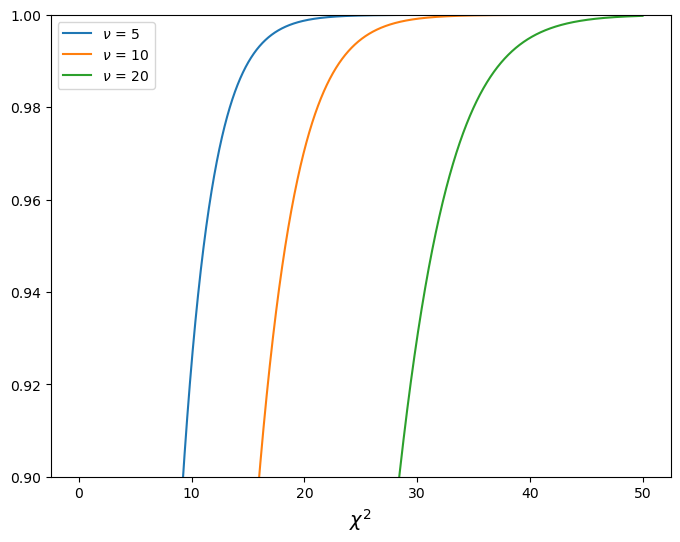

In [18]:
#import matplotlib.pyplot as plt

#list of degrees of freedom
dof=[5,10,20]

chisq=np.arange(0,50,0.01) #a subset of values

#a for-loop plotting the CDF for different degrees of freedom
for i in range(len(dof)):
 plt.plot(chisq,chi2.cdf(chisq,dof[i]),label=r'$\nu$ = {0:d}'.format(dof[i]))
 
#making the plot look nicer
plt.legend(loc='best')
plt.xlabel(r'$\chi^{2}$',fontsize=14)
#plt.ylabel(r'$CDF(\chi^{2})$',fontsize=14)
#plt.yscale('log')
plt.ylim(0.9,1)
plt.show()

For a $\chi^{2}$ test with a given number of degrees of freedom, 1-the CDF of the $\chi^{2}$ distribution gives the _**p-value**_

In [ ]:
#import matplotlib.pyplot as plt

#list of degrees of freedom
dof=[5,10,20]

#a for-loop plotting the CDF for different degrees of freedom
for i in range(len(dof)):
 plt.plot(chisq,1-chi2.cdf(chisq,dof[i]),label=r'$\nu$ = {0:d}'.format(dof[i]))
 
#making the plot look nicer
plt.legend(loc='best')
plt.xlabel(r'$\chi^{2}$',fontsize=14)
plt.ylabel(r'$p value(\chi^{2})$',fontsize=14)
plt.show()

At $\chi^{2}$=10, the $\nu = 5$ curve is again nearly horizontal near a tiny p-value.  The same thing happens for curves corresponding to larger degrees of freedom but at larger $\chi^{2}$ values.

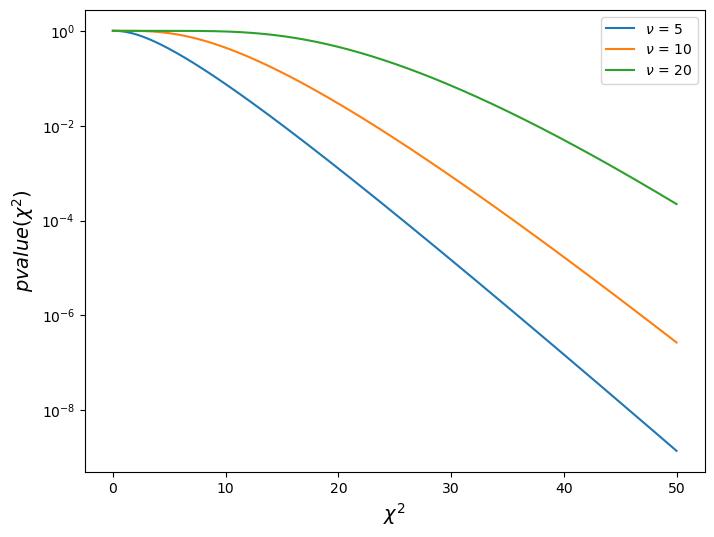

In [20]:
# on a y-log scale...

#import matplotlib.pyplot as plt

#list of degrees of freedom
dof=[5,10,20]

#a for-loop plotting the CDF for different degrees of freedom
for i in range(len(dof)):
 plt.plot(chisq,1-chi2.cdf(chisq,dof[i]),label=r'$\nu$ = {0:d}'.format(dof[i]))
 
#making the plot look nicer
plt.legend(loc='best')
plt.xlabel(r'$\chi^{2}$',fontsize=14)
plt.ylabel(r'$p value(\chi^{2})$',fontsize=14)
plt.yscale('log')
plt.show()



### The meaning of p-values, [something]-$\sigma$, and Probability of a False Detection

Okay, then how do we interpret the results? First, let's consider the case if we are trying to compare a data to some model.  The actual measurement can lie above or below the model prediction. To start with, we need to define the limits we are interested in.  

Oftentimes, you will hear someone say "this is ruled out at the 5-$\sigma$ level" or "this is a 3-$\sigma$ detection", etc.   Quantitatively, what are those numbers?  Well, if we are dealing with Gaussian statistics, we can simply integrate the functional form for a normal distribution and get an answer.

We start with the equation for the normal continuous distribution function:   

$f(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-0.5((x-\mu)/\sigma)^{2}}$.

We have some set of measurements $\nu$ and uncertainties, $\sigma$ to compare with our model prediction $x$.  The fraction of the entire distribution within some n-$\sigma$ range is:

F($\mu$-n$\sigma$ $\le$ X $\le$ $\mu$ + n$\sigma$) = $\int_{\mu-n\sigma}^{\mu+n\sigma} \frac{1}{\sigma\sqrt{2\pi}} e^{-0.5((x-\mu)/\sigma)^{2}}$  

We then do a change of variables z = (x-$\mu$)/$\sigma$ to get 

F($\mu$-n$\sigma$ $\le$ X $\le$ $\mu$ + n$\sigma$) = $\int_{-n}^{n} \frac{1}{\sqrt{2\pi}}e^{-0.5z^{2}}$.

Mathematically, to estimate the expected fraction of the distribution within some $\pm$ n-$\sigma$ range ($\mu$ $\pm$ n-$\sigma$) this is the _error function_ of erf(n/$\sqrt{2}$).


We can solve this numerically using SciPy's integration subpackage.  An example is ``def nsigmalim`` in the ``pdfcdf.py`` script, which we repeat here.

In [24]:

def nsigmalim(nsig=3):
 import scipy.integrate as integrate

 result=integrate.quad(lambda x: np.e**(-0.5*x**2)/np.sqrt(2*np.pi),-nsig,nsig)

 return result[0]


result=nsigmalim(nsig=5)
print(result)
print(1-result)

0.9999994266968565
5.733031435140035e-07


For example, if we do ``from pdfcdf import nsigmalim; nsigmalim(nsig=5)`` we are asking the program to tell us how much of the distribution lies within $\pm$ 5-$\sigma$ limits.   We get ``0.9999994266968565``.  If we take, 1 minus this value, we see how much lies outside these limits: ``5.733031435140035e-07``.  At 1, 2, and 3-$\sigma$ limits we get 0.6826, 0.9544, and 0.9973 lying within and 0.317, 0.0455, and 0.0027 lying outside.

 Now if we know that we are simply trying to compute an error function, the solution is even simpler:
 

In [28]:
from scipy.special import erf #import the error function
nsig=3
result=erf(nsig/np.sqrt(2.))  

print(result)
print('the p value is ',1-result)

0.9973002039367398
the p value is  0.002699796063260207


So what limit are we interested in?  E.g. are we interested in agreement between the model and the data at the 68.2% confidence limit (Gaussian 1$\sigma$), 95.45% (2$\sigma$), 99.73% (3 $\sigma$), etc.?    At 3$\sigma$, we then expect a matching model to be an outlier only 0.27% of the time.   Compare [1-this limit] to our p-value (e.g. approximately 0.05 for 2$\sigma$, 0.0027 for 3$\sigma$).

If the p-value is not low compared to our adopted limit, then the data are consistent
with being drawn from the model.  If the p-value is low, then this model (if correct) would such a p-value from chance very few times: it is likely that the data are not consistent
with being drawn from the model. 

_one sided vs two sided p-values_

Second, let's consider a case where we are trying to see if some purported physical signal is a fluke (i.e. it is a chance positive noise fluctuation).   Here, we are only interested in a detection (i.e. just one side of the area outside a +/- $n\sigma$ range.  Thus, we expect a single true 3-$\sigma$ detection to be a fluke 0.135% of the time (2.7$\times$10$^{-3}$/2 or 1.35$\times 10^{-3}$).   At 5-$\sigma$, this is a tiny 0.5$\times$5.733$\times 10^{-7}$ = 2.867$\times$10$^{-7}$.   These concepts are captured by the False Alarm Probability (FAP) or False Positive Fraction (FPF) in signal detection analyses.

### Caveats and Warnings: the "Look Elsewhere Effect"/"p-hacking"

**WARNING #1** A certain _p-value_ larger than an adopted limit does NOT prove that a given model is the correct one.  Just that IF the model were correct (again IF) at the xxx limit, it would have a p-value larger than some other value.

**WARNING #2**  A very low probability of a false detection does NOT necessarily mean that we are in the clear.   What we can really say is that we expect this signal xx % of the time if a true physical signal does not exist.  E.g.  a random noise fluctuation will appear to be a 3-$\sigma$ outlier 0.27$\%$ of the time (two-sided p value); a random noise fluctuation will appear as a 3-$\sigma$ positive signal about 0.27$\%$/2 = 0.135$\%$ of the time (one-sided p value). 

In other words, if your detection threshold corresponds to a 1% probability that the detection is noise, then 1% of the time a signal exceeding your detection threshold will in fact be noise (i.e a 'false detection').  

Here's a case of the danger in case #2 [sorry, this is another exoplanet imaging example] ...

  Let's say you have some signal in our data that appears brighter than the rest.   In fact, if you compute the signal compared to the standard deviation of other regions -- i.e. you are comparing it to an estimate of the cumulative distribution function of other signals -- you find that it is a 3-$\sigma$ significant positive outlier.   So you would naively think that there is a 0.135% chance that this detection is faulty.  That's a super-low probability.   All done, right?  

No.  Because this signal is on some detector with some area.   The real question you want to answer is "_what are the chances that there is a false detection **somewhere** on this image_"?   To answer that, you need to take the total area of your detector and divide by the area of a planet signal (jargon jargon "the PSF core size") and multiply this number by the probability of a single 3-$\sigma$ detection.

A worked example:

* camera = 200 pixels by 200 pixels; pixel scale of 0.01"/pixel
* 8 meter telescope at 1.6 microns

* So ... the PSF core size is about $FWHM = 1.028x0.206\lambda/D$ = 0.042" or 4.23 pixels.   The area of a PSF core is then $\pi (FWHM/2)^{2}$ or 14.1 pixels$^{2}$ in area.  The detector area is 200 by 200 = 40,000 pixels$^{2}$ so we have 40,000/14.1 = 2837 independent PSF-sized regions.   

Multiply this number of independent regions by the p-value of a 3-$\sigma$ detection and you find that you should get about four 3-$\sigma$ peaks on your detector purely by chance!   So the fact that you have at least _one_ 3-$\sigma$ peak is completely expected!

The flaw in reasoning thinking that you have identified a planet in the above case is an example of the "look-elsewhere effect": where an apparently high-significance signal in a very large data set actually arises from chance.

We can explore this concept in the example above ...

| σ level | One-sided p-value (a positive signal/detection) | Two-sided p-value (an outlier of some kind)| Expected false positives per 1 trial | Expected false positives in 2837 independent trials (e.g., 200×200 detector / PSF core) |
| ------- | ----------------- | ----------------- | ------------------------------------ | --------------------------------------------------------------------------------------- |
| 1σ      | 15.87%            | 31.74%            | 0.1587                               | 2837 × 0.1587 ≈ 450                                                                     |
| 2σ      | 2.28%             | 4.56%             | 0.0228                               | 2837 × 0.0228 ≈ 65                                                                      |
| 3σ      | 0.135%            | 0.27%             | 0.00135                              | 2837 × 0.00135 ≈ 3.8                                                                    |
| 4σ      | 0.00317%          | 0.00634%          | 3.17×10⁻⁵                            | 2837 × 3.17×10⁻⁵ ≈ 0.09                                                                 |
| 5σ      | 2.87×10⁻⁷         | 5.73×10⁻⁷         | 2.87×10⁻⁷                            | 2837 × 2.87×10⁻⁷ ≈ 0.0008                                                               |


Basically, you have a huge data set what could possibly be correlated with the data?  Well, if you search long and hard enough you are bound to find _something_ that is correlated with your data at some confidence level.   And if you have a large enough detector, you are bound to find some 3-$\sigma$ noise blip _somewhere_.

The "look elsewhere effect" is conceptually related to "p-hacking", where you selectively search through large data sets to find "something" that appears significant or correlated and concluding that _this_ apparently correlation identifies a causal relationship. 

An example ...

![](./figures/PiratesvsTemp.png)

### From $\chi^{2}$ to n-$\sigma$

Now we can ask the question in reverse.  Say you are comparing some model with $\nu $ degrees of freedom to your data which has a set of measurements and uncertainties in those measurements.  You compute the $\chi^{2}$ statistic as described above and you get some answer and think that the model is an outlier.  How many $\sigma$ of an outlier is it?

Now we just compute the _inverse_ error function, which is accessed through SciPy as well.

Now, remember the interpretation of $\chi^{2}$ depends on the number of degrees of freedom.  So you might naturally think (correctly) that we need the number of degrees of freedom in here somewhere as well.  

here's an example where we compute a chisq value of 100 and have two degrees of freedom.

In [29]:
from scipy import special,stats

chisqval=100
ndof=2
result=special.erfcinv(stats.chi2.sf(chisqval, ndof))*2**0.5

print(result)

9.745474864965937


Now, where we have the same chisquared value but have 87 degrees of freedom.

In [30]:
chisqval=100
ndof=87
result=special.erfcinv(stats.chi2.sf(chisqval, ndof))*2**0.5

print(result)

1.4016589442961531


Only 1.4$\sigma$ deviant.   In fact, this is really close to what we expect for an accurate model if our measurement errors are correct

In [31]:
print(1+np.sqrt(2/ndof))

1.1516196087157806


_$\Delta \chi^{2}$ and Parameter Estimation_ 

We have a large number of models to which we are comparing to data.  The model have some different variations of input parameters.   One example I deal with regularly: planet atmosphere models with some certain prescription for clouds and then some range in other properties like temperature (say, 500 K to 2000 K), gravity (say log(g) = 3 to 5), and metallicity (say [M/H] = -1 to 1).

We now have two follow-up questions: 1) how would we describe the family of "best-fitting solutions", 2) how would we describe the confidence region for parameters from these models?   

The answer lies in the $\Delta \chi^{2}$ values.   Here, 

$\chi^{2}$ = $\chi^{2}_{min}$ + $\Delta \chi^{2}$.   I.e. we have some value that is our best-fitting model, which we call $\chi^{2}_{min}$ (because it has the minimum $\chi^{2}$ value).   The family of best-fitting models is defined _relative_ to this minimum, i.e by the $\Delta \chi^{2}$ value.

Parameter estimation is conceptually simpler and leverages specifically on $\Delta \chi^{2}$.   To perform this, we define contours of constant   $\chi^{2}$ = $\chi^{2}_{min}$ + $\Delta \chi^{2}$.   If we are wanting a joint confidence region for two parameters (say, temperature and gravity from my example) then we compute the regions where:

 $\chi^{2}$ - $\chi^{2}_{min}$ $<$ $\Delta \chi^{2}$
 
 Fine, but what _is_ $\Delta \chi^{2}$?   The $\Delta \chi^{2}$ values depend on the number of variables in our joint estimation and confidence limits.  E.g. for a two-variable joint estimation:
 
   The 68.2% (1-$\sigma$) confidence limit is $\Delta \chi^{2}$ $\le$ 2.30
   
   The 95.45% (2-$\sigma$) confidence is $\Delta \chi^{2}$ $\le$ 6.17
   
   The 99.73% (3-$\sigma$) confidence limit is $\Delta \chi^{2}$ $\le$ 11.8
   

This follows from the $\chi^{2}$ to n-$\sigma$ calculation above:

In [32]:
chisqval=[2.3,6.17,11.8]
ndof=2
result=special.erfcinv(stats.chi2.sf(chisqval, ndof))*2**0.5

print(result)

[1.00139316 1.99787666 2.99555657]


   An example of this trend is from some analysis below of the HIP 99770 b planet, where we compared its data to models spanning a range of temperatures and gravities (for a given set of fixed other atmospheric properties).
   
  
![](./figures/Figure_19.png)

#### Student's t-distribution and t-test

Much of the above notes were focused on cases where i) the sample size is large and ii ) the **population variance** is known (i.e. you have every single data point for the population you are interested in).  In these cases, the data could be well described by a normal (Gaussian) distribution.

The key difference between the t-distribution and a normal distribution is as follows.  With a normal distribution, we assume that we have perfect knowledge of the population standard deviation and we have a ton of samples.   With a t-distribution, we do not make these assumptions: the t-distribution adjusts for our lower confidence in our ability to estimate the true underlying distribution when we have small sample sizes.  And quite often in astrophysics, we encounter the case where we only have a small number of samples.  

Context: The t-statistic was introduced in 1908 by William
S. Gosset, a chemist working for the Guinness brewery. He was concerned about
comparing different batches of the stout, in particular when there were only a small number of batches to work with (Guiness was a smaller operation 100+ years ago).

 He developed
the t-test, and the t-distribution for that purpose. According to legend, Guiness forbade him from publishing his results (because others would steal it and rob Guiness of its competitive advantage?), so Gosset anonymously published his mathematical work under
the pseudonym “Student”.  Hence the term "Student's t-test" and "t-distribution".

The _one sample_ "t-statistic" is of form:

$t$ = $\frac{X-\mu}{S/\sqrt{n}}$,

where $S$ is the sample standard deviation, $n$ is the sample size, $\mu$ is the true mean and X is the sample mean.

The _two sample_ "t-statistic" is of form:

$t$ = $\frac{X1-X2}{\sqrt{S_{1}^{2}/n_{1} + S_{2}^{2}/n_{2}}}$

A one-sample t-statistic tests if a single sample mean differs from a hypothesized population value, while a two-sample t-statistic compares the means of two independent groups to see if they are statistically different

The functional form of the t-distribution looks as follows:

 
$f(t)$ = $\frac{\Gamma(\frac{\nu+1}{2})}{\Gamma(0.5\nu)\sqrt{\nu\pi}}(1 + t^{2}/\nu)^{-\frac{\nu+1}{2}}$

Gamma functions all over the place.  Practically speaking, how does it differ?  To demo that, you can run ``def tdist`` from ``pdfcdf.py``.

Here, I will illustrate the behavior of the t distribution as we go from a small number of degrees of freedom to a very large number:

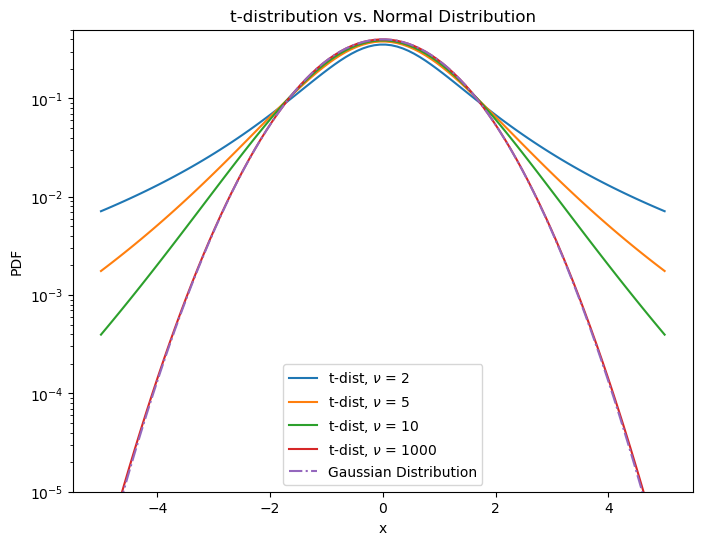

In [39]:

def tdist():
 from scipy.stats import t
 from scipy.stats import norm


#t distribution PDF


 x=np.linspace(-5,5,100)

 dof=[2,5,10,1000]

#to apply some other normalization
 maxt=1;maxnorm=1

 for i in range(len(dof)):

   plt.plot(x,t.pdf(x,dof[i])/maxt,label=r't-dist, $\nu$ = {0:d}'.format(dof[i]))


#Now, plotting a Gaussian distribution
 plt.plot(x,norm.pdf(x)/maxnorm,ls='-.',label='Gaussian Distribution')

 plt.xlabel('x')
 plt.ylabel('PDF')
 plt.yscale('log')
 plt.title('t-distribution vs. Normal Distribution')

 plt.legend(loc='best')

 plt.ylim(1e-5,0.5)
 #plt.show()

tdist()


The t-distribution has a slightly flatter peak and much fatter tails of its distribution than does a normal distribution.

_Applications_

There are a lot of applications of t-distributions and t-tests.  

one-sample t-test (key feature: you have some sample and some fixed comparison value: you have some X and some $\mu$)
* testing if the average heart rate of some group of patients differs from 75 bps
* a scale should read 0 when no one is on it.  After 30 measurements, the average is 0.2 g.  Is the scale miscalibrated?




My personal favorite is again with exoplanet imaging.   Remember that quoted 3-$\sigma$ "detection" of a planet mentioned before?   You saw how you might expect many more spurious detections if you consider all possible realizations of the noise over the size of your detector.  The situation is actually worse, if you realize the implications of the t-distribution.

Namely, the usual approach to computing the noise in exoplanet imaging data is to compare the signal within one region (typically a PSF core size) to that of other similarly sized regions at the same separation from the star (because the noise is primarily a function of radial separation ...[yada, yada ignore tech details]".  So you compute the noise and get some estimate for the standard deviation.   You use this information to compute the noise as a function of r to compute some contrast limit (i.e. a limit on how bright a planet you can detect relative to the brightness of the star).   Or you compare that to the other PSF-sized region where you think there is a planet.  

But here's the problem, the number of independent samples from which you are estimating the noise is not very large: maybe tens or so?   And in fact it is smaller the closer you get to the star, as illustrated in this image from Mawet et al. (2014):


![](./figures/mawet.png)

So, if you are at a separation of 1 $\lambda$/D from the star, you only have 2$\pi$ $\sim$ 6 independent samples from which to estimate the noise.  So your number of degrees of freedom is going to be tiny.

Using SciPy, we can compute the impact of small sample statistics.  The specifics are beyond the scope of this course (if you are really interested, here's the paper [https://iopscience.iop.org/article/10.1088/0004-637X/792/2/97/pdf]().  1) you have to account for an extra factor of $\sqrt{1 + 1/n}$ where $n$ is the number of samples. 2) you are actually doing a two-sample t-test, determining whether the one sample (i.e. where your candidate planet is) is different form the others (the other regions of the image that define the noise).   So the number of degrees of freedom is 2$\pi$r-2 (r is in $\lambda$/D units).

In [80]:

def tpenalty(sep=2,sigma=5,source=True):


 from scipy.stats import t
 from scipy.stats import norm


 res_el=2*np.pi*sep

#note: some slight disagreement between ...
# the text of the paper, 
#code implementations 
#and Table 1/Figure 6: 

#res_el=np.floor(res_el) #res_el = np.round(res_el) 
 
#My code will recover Table 1/Figure 6 values, which you can recover if you do not adjust res_el


#Table 1/Figure 6 entries
 if source:

  ss_corr=np.sqrt(1+1/(res_el))
  penalty = t.ppf(norm.cdf(sigma),res_el-2)*ss_corr/sigma


#if we are doing a contrast curve, instead of evaluating a possible planet detection
# then we gain a DOF

 else:

  ss_corr=np.sqrt(1+1/res_el)
  penalty = t.ppf(norm.cdf(sigma),res_el-1)*ss_corr/sigma

 print('penalty is ',penalty)
 return penalty


tpenalty()

penalty is  2.206523175207393


2.206523175207393

As you can see, the correction factor can be substantial: a factor of 10 at 1 $\lambda$/D and 2.2 at 2 $\lambda$/D for a 5-$\sigma$ threshold.

### Statistical tests with t-distributions

In [40]:
def example_onesamp_ttest(meanval=5.0,arrayin=None):

    # Perform two-sided one-sample t-test
 t_statistic, p_value = stats.ttest_1samp(x, popmean=meanval)

 print('t-statistic = {0:.3f}'.format(t_statistic))
 print('two-sided p-value = {0:.4f}'.format(p_value))

# Interpretation
 alpha = 0.05  # significance level
 if p_value < alpha:
    print("Reject the null hypothesis: sample mean differs significantly from mu0")
 else:
    print("Fail to reject the null hypothesis: sample mean is consistent with mu0")

     

In [41]:
x = np.array([5.1, 4.9, 5.0, 5.2, 5.1])

example_onesamp_ttest(meanval=5.0,arrayin=x)

t-statistic = 1.177
two-sided p-value = 0.3046
Fail to reject the null hypothesis: sample mean is consistent with mu0


In [42]:
def example_twosided_ttest(array1=None,array2=None):

# Perform two-sided independent t-test (assumes unequal variance by default)
 t_statistic, p_value = stats.ttest_ind(a, b, equal_var=False)
 print('t-statistic = {0:.3f}'.format(t_statistic))
 print('two-sided p-value = {0:.4f}'.format(p_value))

 # Interpretation
 alpha = 0.05  # significance level
 if p_value < alpha:
    print("Reject the null hypothesis: means of A and B differ significantly")
 else:
    print("Fail to reject the null hypothesis: means of A and B are consistent")

In [43]:
a = np.array([5.1, 4.9, 5.0, 5.2, 5.1])
b = np.array([5.3, 5.4, 5.2, 5.5, 5.3])
example_twosided_ttest(array1=a,array2=b)

t-statistic = -3.883
two-sided p-value = 0.0047
Reject the null hypothesis: means of A and B differ significantly


---

There are many more possible applications we can consider of the t-test, other statistics mentioned above, and other statistic test implementations in Python (e.g. the Kolmogorov-Smirnov test, Shapiro-Wilk Test, Spearman's Rank Correlation, etc.).  But we will stop here for now.